## Multi-layer Perceptrons and XOR Logic

**Perceptrons: an introduction to computational geometry** is a book written by Marvin Minsky and Seymour Papert and published in 1969.

In this book, the authors imply that, since a single artificial neuron is incapable of implementing some functions such as the XOR logical function, larger networks also have similar limitations, and therefore should be dropped.

Later research on three-layered perceptrons showed how to implement such functions, therefore saving the technique from obliteration.

We will show how to build, train and run a Multi-layer Perceptron (MLP) to implement XOR logic.

### Configure

In [3]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib
import numpy as np
import functools

batch_size = 64
nr_class = 2

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)


### Dataset

In [4]:
def minibatch_generator():
    while True:
        inp_data = np.zeros((batch_size, 2))
        label = np.zeros(batch_size, dtype=np.int32)
        
        for i in range(batch_size):
            inp_data[i, :] = np.random.rand(2) * 2 - 1  # [x0, x1], sampled from U[-1, 1]
            label[i] = 0 if np.prod(inp_data[i]) < 0 else 1
                
        yield {'data': inp_data.astype(np.float32), 'label': label}

### Build a graph

In [6]:
# init
weight_init = tf_contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN', uniform=False)
bias_init = tf.zeros_initializer()
fc_layer = functools.partial(tf.layers.dense, kernel_initializer=weight_init, bias_initializer=bias_init)

# setup inputs
data = tf.placeholder(tf.float32, shape=(None, 2), name='data') # input data is Nonex2, None means any value, 2 is feature size
label = tf.placeholder(tf.int32, shape=(None, ), name='label') # label indicates the categories of input features
label_onehot = tf.one_hot(label, nr_class, dtype=tf.int32) # convert the format of label to onehot

# build a network
x = fc_layer(inputs=data, units=14, name='fc0')
x = tf.nn.tanh(x)
x = fc_layer(inputs=x, units=14, name='fc1')
x = tf.nn.tanh(x)
logits = fc_layer(inputs=x, units=2, name='fc2')
preds = tf.nn.softmax(logits)
loss = tf.losses.softmax_cross_entropy(label_onehot, logits) 

# set a performance metric
correct_pred = tf.equal(tf.cast(tf.argmax(preds, 1), dtype=tf.int32),
                        tf.cast(tf.argmax(label_onehot, 1), dtype=tf.int32))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Training

In [7]:
# load dataset
train_dataset = minibatch_generator()
val_dataset = minibatch_generator()

# recorder
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# training config
opt = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9)
train = opt.minimize(loss)

tf.set_random_seed(12345) # ensure consistent results

# create a session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # init all variables
    # training
    for step, minibatch in enumerate(train_dataset): 
        if step > 2000:
            break
         
        # run train, and output all values you want to monitor
        _, loss_v, acc_v= sess.run([train, loss, accuracy], 
                                   feed_dict={data: minibatch['data'], label: minibatch['label']})
        train_loss.append((step, loss_v))
        train_accuracy.append((step, acc_v))
        
        if step % 50 == 0:
            minibatch = next(val_dataset)
            loss_v, acc_v= sess.run([loss, accuracy], 
                                    feed_dict={data: minibatch['data'], label: minibatch['label']})
            val_loss.append((step, loss_v))
            val_accuracy.append((step, acc_v))

print('Training is done, exit!')

Training is done, exit!


### Monitor

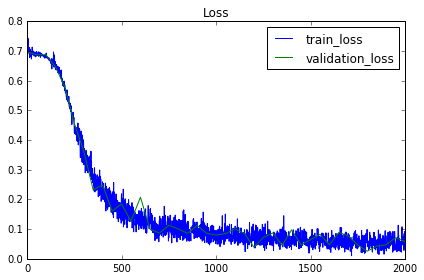

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.title('Loss')
for xy, name in ((train_loss, 'train_loss'), (val_loss, 'validation_loss'), ):
    xy = np.array(xy)
    x, y = xy[:, 0], xy[:, 1]
    plt.plot(x, y, label=name)
plt.legend()
plt.tight_layout()

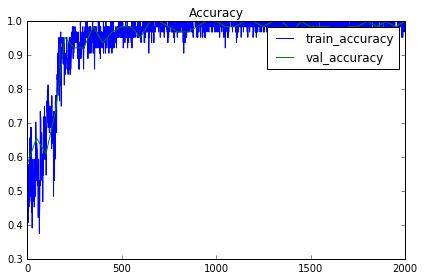

In [11]:
plt.figure()
plt.title('Accuracy')
for xy, name in ((train_accuracy, 'train_accuracy'), (val_accuracy, 'val_accuracy'), ):
    xy = np.array(xy)
    x, y = xy[:, 0], xy[:, 1]
    plt.plot(x, y, label=name)
plt.legend()
plt.tight_layout()